# Data Preparation

In [356]:
import pandas as pd

file_path = 'data.csv'
data = pd.read_csv(file_path)

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True) 

X = data.drop(['ggr'], axis=1)
y = data['ggr']

In [357]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split

# Normalizing features and target
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Function to create sequences for LSTM model
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30

X_seq, y_seq = create_dataset(X_scaled, y_scaled, time_steps)

# Splitting into training and testing sets
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False
)

dates_train, dates_test = train_test_split(
    data.index, test_size=0.2, random_state=42, shuffle=False
)

X_train_seq.shape, y_train_seq.shape


((1050, 30, 5), (1050, 1))

# Model v.1

Epoch 1/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0291 - val_loss: 0.0080
Epoch 2/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031 - val_loss: 0.0080
Epoch 3/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - val_loss: 0.0068
Epoch 4/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - val_loss: 0.0067
Epoch 5/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - val_loss: 0.0096
Epoch 6/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - val_loss: 0.0073
Epoch 7/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021 - val_loss: 0.0084
Epoch 8/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023 - val_loss: 0.0068
Epoch 9/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0076
Epoch 10/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031 - val_loss: 0.0070
Epoch 11/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - val_loss: 0.0081
Epoch 12/150
120/120 ━━━━━━━━━━━━━━━━━━━━

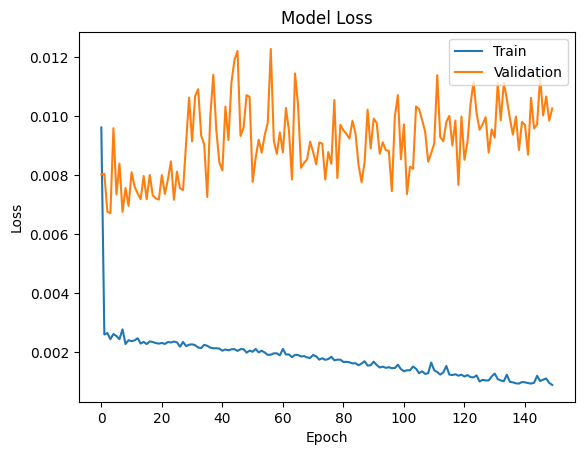

In [312]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import numpy as np
import matplotlib.pyplot as plt


model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),  
    LSTM(100),  
    Dense(1)  
])


model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train_seq, 
    y_train_seq, 
    epochs=150, 
    batch_size=7,  
    validation_split=0.2,  
    verbose=1 
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
MAPE: 8.944672917191369 %
NRMSE: 0.0603240171049347


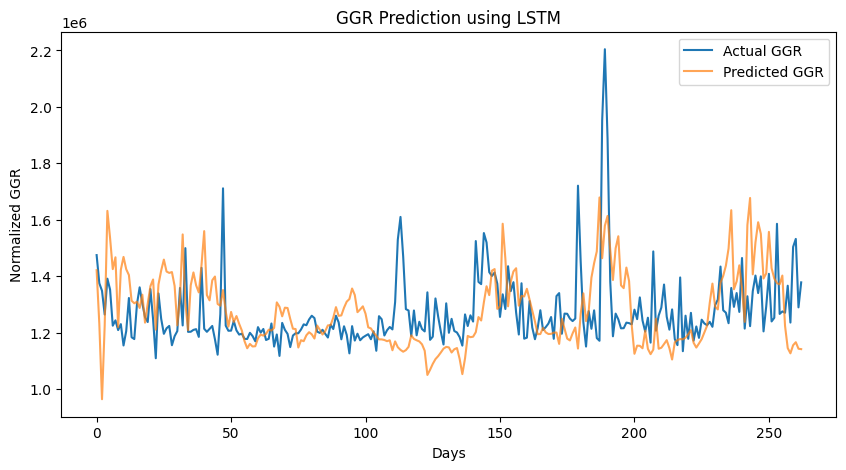

In [313]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  
y_test = scaler_y.inverse_transform(y_test_seq)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = root_mean_squared_error(y_test, y_pred)
nrmse = rmse / (data['ggr'].max() - data['ggr'].min())

print("MAPE:", mape, "%")
print("NRMSE:", nrmse)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual GGR')
plt.plot(y_pred, label='Predicted GGR', alpha=0.7)
plt.title('GGR Prediction using LSTM')
plt.xlabel('Days')
plt.ylabel('Normalized GGR')
plt.legend()
plt.show()


# Model v.2

Epoch 1/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0192 - val_loss: 0.0100
Epoch 2/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0030 - val_loss: 0.0099
Epoch 3/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0033 - val_loss: 0.0117
Epoch 4/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0032 - val_loss: 0.0107
Epoch 5/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 6/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 0.0117
Epoch 7/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0034 - val_loss: 0.0106
Epoch 8/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - val_loss: 0.0142
Epoch 9/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031 - val_loss: 0.0114
Epoch 10/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0022 - val_loss: 0.0101
Epoch 11/200
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - val_loss: 0.0108
Epoch 12/200
135/135 ━━━━━━━━

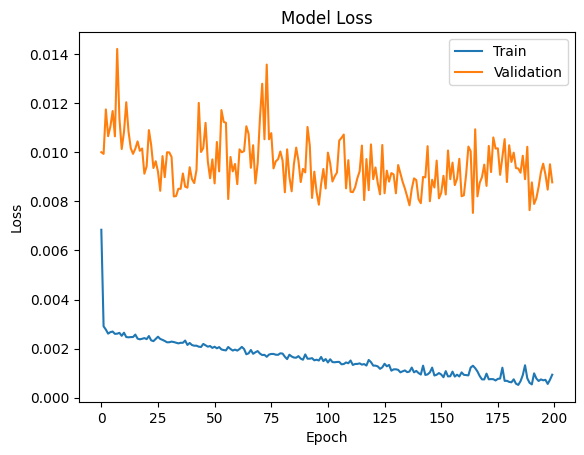

In [339]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

model = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(100, return_sequences=True),
    Dropout(0.1), 
    LSTM(50, return_sequences=True),
    Dropout(0.2), 
    LSTM(30), 
    Dense(1)  
])

model.compile(optimizer='Adam', loss='mean_squared_error')
history = model.fit(
    X_train_seq, 
    y_train_seq, 
    epochs=200,  
    batch_size=7,
    validation_split=0.1,
    verbose=1
)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [340]:
from sklearn.metrics import mean_squared_error

y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  

y_test = scaler_y.inverse_transform(y_test_seq)
y_train = y[:round(y.shape[0]*0.8)]

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
rmse = root_mean_squared_error(y_test, y_pred)
nrmse = rmse / (data['ggr'].max() - data['ggr'].min())

print("MAPE:", mape, "%")
print("NRMSE:", nrmse)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
MAPE: 7.008646453195622 %
NRMSE: 0.0532529585800248


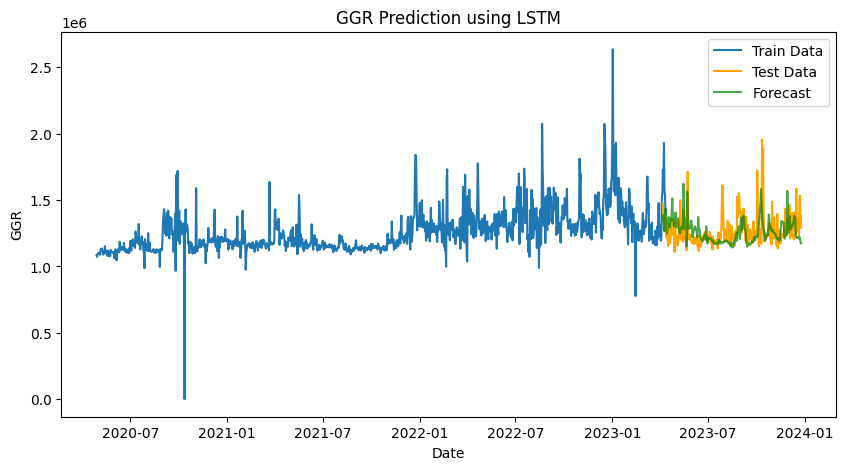

In [359]:
dates_pred = dates_test[:len(y_pred)]
dates_test = dates_test[:len(y_test)]

plt.figure(figsize=(10, 5))
plt.plot(y[:-len(y_test)].index, y[:-len(y_test)], label='Train Data')
plt.plot(dates_test, y_test, label='Test Data', color='orange')
plt.plot(dates_pred, y_pred, label='Forecast', color='green', alpha=0.7)
plt.title('GGR Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('GGR')
plt.legend()
plt.show()

In [351]:
# Save the model to disk
model.save_weights('lstm.weights.h5')